# Imports

In [1]:
# help here: 
#  - https://www.youtube.com/watch?v=nNvPvvuPnGs 
#  - https://github.com/rsreetech/LDATopicModelling/blob/main/LDADemo.ipynb

import os
import time
import math
import warnings
from IPython.display import clear_output, HTML

import numpy as np
import pandas as pd
from pandarallel import pandarallel

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud
import pprint

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim

# Configuration

In [2]:
PREVIEW_REVIEW_SIZE = 1000
CHUNK_SIZE = 10000
EXTRACT_PARQUET = False
PREPROCESS_IMAGES = False
EXTRACT_CNN_FEATURES = False

# SAMPLINg
SAMPLING_REVIEW_SIZE = 1000
SAMPLING_PHOTOS_SIZE = 100

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
ORIGINAL_PHOTOS_DIR = 'data/original/yelp_photos/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
WORK_PHOTOS_DIR = 'data/work/yelp_photos/'

PREFIX_YELP = 'yelp_academic_dataset_'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=matplotlib.MatplotlibDeprecationWarning)

sns.set()
pandarallel.initialize(progress_bar=True, verbose=False)

# Trick for jupyter lab with pyLdaVis
css_str = """<style> 
    .jp-Button path { fill: var(--jp-inverse-layout-color3);}
    .lm-TabBar-tabIcon path { fill: var(--jp-inverse-layout-color3);}
    .jp-icon-warn0 path {fill: var(--jp-inverse-layout-color3);}
    .bp3-button-text path {    fill: var(--jp-inverse-layout-color3);}
    .jp-icon-brand0 path { fill: var(--jp-inverse-layout-color3);}
    text.terms { fill: var(--jp-inverse-layout-color3);}
</style>"""  
display(HTML(css_str))

# Extractions des sujets des reviews

In [3]:
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_REVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df   

## Prévisualiastions des datasets

In [4]:
files = list_files(ORIGINAL_DATASET_DIR)
print('')
print(tabulate([[k,v] for k,v in files.items()]))

Name                                 Size
-----------------------------------  ------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb

--------  --------------------------------------------------------------
business  data/original/yelp_dataset/yelp_academic_dataset_business.json
checkin   data/original/yelp_dataset/yelp_academic_dataset_checkin.json
review    data/original/yelp_dataset/yelp_academic_dataset_review.json
tip       data/original/yelp_dataset/yelp_academic_dataset_tip.json
user      data/original/yelp_dataset/yelp_academic_dataset_user.json
--------  --------------------------------------------------------------


In [5]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



business_id                                    name  \
560  OYmwoFmoEIA0rx7jd6ZWsg                          Tattoos by Taz   
968  3swM60bulnut1d4AZti80Q                        Rockabilly Grill   
862  3L-cbPMvNbsG9vmOF5QHEQ  Idaho Center For Reproductive Medicine   
345  XwoXi0M66RU6Gouq-DSDHw                G Peppers Grill & Tavern   
829  fI8kWao4ejLDDGgWNxKiHw                     Edible Arrangements   

                       address         city state postal_code   latitude  \
560      3767 Gen De Gaulle Dr  New Orleans    LA       70122  30.000842   
968           3700 N Oracle Rd       Tucson    AZ       85705  32.273989   
862  1000 E Park Blvd, Ste 110        Boise    ID       83712  43.603023   
345              8745 Gunn Hwy       Odessa    FL       33556  28.092136   
829           2416 Elliston Pl    Nashville    TN       37203  36.148282   

      longitude  stars  review_count  is_open  \
560  -90.058293    4.0            10        1   
968 -110.977534    3.5            37        1   
862 -116.187203    3.5            13        1   
345  -82.578574    4.0            82        1   
829  -86.808166    2.5            12        1   

                                            attributes  \
560  {'BikeParking': 'False', 'BusinessAcceptsCredi...   
968  {'RestaurantsTakeOut': 'True', 'RestaurantsDel...   
862                      {'ByAppointmentOnly': 'True'}   
345  {'RestaurantsGoodForGroups': 'True', 'Restaura...   
829  {'RestaurantsPriceRange2': '2', 'BusinessAccep...   

                                            categories  \
560                    Tattoo, Piercing, Beauty & Spas   
968  Nightlife, American (New), Music Venues, Resta...   
862  Fertility, Obstetricians & Gynecologists, Doct...   
345       Restaurants, Mexican, American (Traditional)   
829  Flowers & Gifts, Chocolatiers & Shops, Florist...   

                                                 hours  
560  {'Monday': '14:0-0:0', 'Tuesday': '14:0-0:0', ...  
968  {'Monday': '10:0-2:0', 'Tuesday': '10:0-2:0', ...  
862  {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...  
345  {'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...  
829  {'Monday': '8:0-19:0', 'Tuesday': '8:0-19:0', ...

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



business_id                                               date
85   -1PG6k_iezwJmRZLB7f6og  2017-10-13 17:34:02, 2017-10-13 18:57:28, 2017...
959  -SguV7aNlTXbsdkyJI4baw  2010-11-20 03:58:49, 2011-01-16 02:21:02, 2011...
400  -AyTHdUwHI-u5vAuXhUpPw  2013-06-05 00:02:09, 2013-06-06 20:54:34, 2013...
939  -SL4pxguo0YQlEcOFZLEGQ  2010-08-31 22:18:39, 2010-10-03 21:41:25, 2010...
672  -JStjL-8mRZq4ov4uI1FaQ  2010-07-18 20:43:51, 2010-08-19 02:06:33, 2010...

business_id    object
date           object
dtype: object


PREVIEW review



review_id                 user_id             business_id  \
343  FpWzaYsVDGrU8w3134s1jg  1HQ3yuhqVJPqjCz1P6fDeA  VVvUBlc_WIEb8obKGq39dA   
360  OMUO1w4zd02SWAtdPOOmDw  V5N8EVTjBlCiUzD72Rov2Q  V378VWx4D8BstWNRFwDULg   
920  EWmkTBDTjOQpckZtyMudIQ  IZ6HdSnPbJqvvG4S6GBaWg  oqP1oQEycpp4J6u5YebRoQ   
950  cp12LEo_c7SNbpscnbYjfA  1sgV5TOLiKCCi84No37qCA  qONvIS94nZhXYm-jccXyuw   
442  0PF3_gnx3oI48Q4xi3D0uA  __GHy1xxetn0SBqP4b_odA  L3V21nAe-CicW2bvtNWa0g   

     stars  useful  funny  cool  \
343      4       2      0     2   
360      1       0      0     0   
920      1       0      0     0   
950      3       1      0     1   
442      3       0      0     0   

                                                  text                date  
343  Nice little bar located at the very far end of... 2016-10-13 22:00:07  
360  Whole family got sick after eating here. The f... 2018-07-08 01:39:26  
920  After numerous visits here, we really wanted t... 2018-07-26 14:21:11  
950  Four stars for price. \nI drive truck, so I've... 2018-03-15 20:12:40  
442  Not the best prepared sushi inthe city by a lo... 2010-08-22 00:01:33

review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



user_id             business_id  \
108  WhjYxQIiAIZPkVqUqSBDbg  LG80KAbnjI3fICP99UE9RQ   
896  OQAGEtVja9YrXa3KhSp1OA  yX0P0_JV1imBE46I1ZMEaA   
775  S87SqA07uE4DCr3-RnMrdQ  yjcIKn2T2QY_DjXWACsAFw   
20   FQ-zmWPEG_pjSQx6pt3Efw  3ZynJ94VpIdDlaArmEp2Rg   
872  xdWduB5v4azIBQjRBDsIDg  WM_A6hPGmcRXHhZMPAMTXg   

                                                  text                date  \
108                          The people here are rude, 2017-06-23 23:03:51   
896  Don't come after noon if you want a bagel. Tot... 2015-09-12 17:36:14   
775  Best worst place I have ever been too but orde... 2015-05-24 18:57:30   
20              Yes, I'm eating here again. Breakfast! 2012-10-12 15:16:13   
872                         Great food. Great service. 2016-01-23 16:25:58   

     compliment_count  
108                 0  
896                 0  
775                 0  
20                  0  
872                 0

user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



user_id      name  review_count        yelping_since  \
434  pMltyeuU4SjT6Y8YVy7HBA      Tony          1139  2006-06-21 15:41:53   
840  KxrTQnzr83z0HZnrAkkeGQ  Michelle           484  2008-03-17 21:17:45   
695  KmUFaI21IQfQWajv3BrEgw   Timothy            79  2011-03-29 22:05:31   
412  in672plSIGcbOj2q5moYwg   Cricket           212  2010-09-19 07:20:27   
561  8diIRer3uONzEKAQzUbQMw   Rosslyn            27  2010-07-14 02:17:56   

     useful  funny  cool                                              elite  \
434    1648    681   932  2008,2009,2010,2011,2012,2013,2014,2015,2016,2...   
840     918    193   303            2009,2010,2011,2012,2013,2014,2015,2016   
695      78     31    19                                                      
412    1305    773   687                           2010,2011,2012,2013,2014   
561      28     11    11                                                      

                                               friends  fans  ...  \
434  YUxH_F9jMGAe7PIe8DO34Q, oW2bCSJ5bIHyRnoZvkHwDg...    58  ...   
840  jmyunODJvYT7n7LCgotAyQ, 9v-5eRVUgXE5DqWg6RdgOg...    40  ...   
695  L5D9SSUWjLlAlEQFvHhE7A, QpJPMVh9HtzlXafiPEhSBA...     4  ...   
412  RRuUEZ--a9rtnqjyoDHfXw, XS4rYA1V_Ru7tyf0Jl15aw...    39  ...   
561  Rjd9Td7yYOqu0A1e2KDAyA, ydFC6N5RkzsY9zcCNIqZuQ...     4  ...   

     compliment_more  compliment_profile  compliment_cute  compliment_list  \
434                5                  11                2                1   
840                3                   7                4                2   
695                1                   0                0                0   
412                7                   3                4                7   
561                0                   0                0                0   

     compliment_note  compliment_plain  compliment_cool  compliment_funny  \
434               44                94               76                76   
840               13                29               38                38   
695                2                 1                3                 3   
412              101               260              192               192   
561                1                 2                0                 0   

     compliment_writer  compliment_photos  
434                 31                 11  
840                  5                  5  
695                  3                  0  
412                 44                 10  
561                  0                  0  

[5 rows x 22 columns]

user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

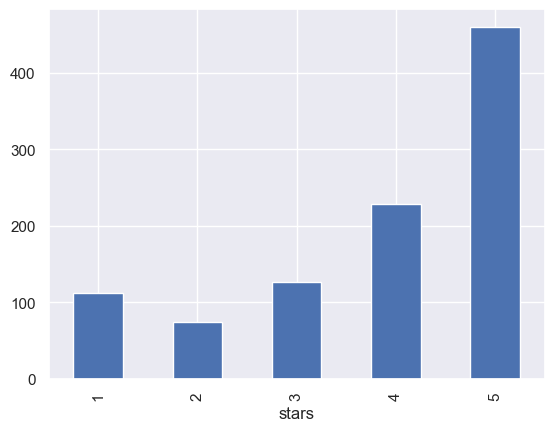

In [6]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [7]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [8]:
review = preview_dfs['review']
for star in range(1,6):
    title = HTML(f'<h3 style="">Note = {star}<br><hr></h3>')
    display(title)
    for index in review[review['stars']==star].sample(2, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        quote = HTML(f'<div style="border-left: 4px solid yellow; padding-left:10px; margin-bottom:20px;">{text}</div>')
        display(quote)

<Axes: xlabel='class'>

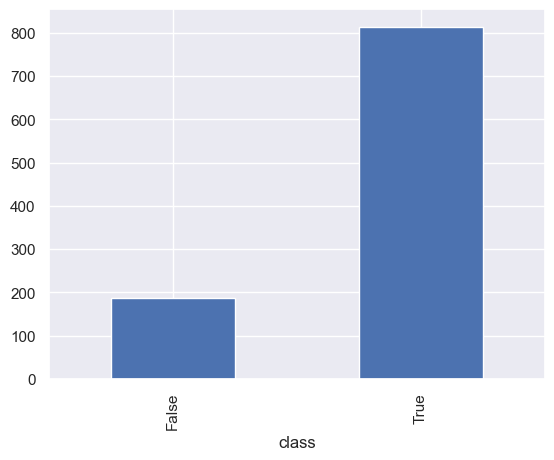

In [9]:
bad_stars = 2
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > bad_stars
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

In [10]:
sampling_coef_bad = preview_dfs['review']['class'].value_counts()[False]/preview_dfs['review']['class'].value_counts()[True]
print(f'{sampling_coef_bad*100:.0f}% des reviews ont au maximum {bad_stars} étoiles')

23% des reviews ont au maximum 2 étoiles


## Extraction d'un échantillons de reviews

### Recensement des catégories de business

In [11]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

51551                                 [Indian, Restaurants]
150052    [Food, Mexican, Seafood, Barbeque, Cuban, Rest...
28021     [Real Estate, Home Services, Home Organization...
27594     [Salad, Sandwiches, Southern, Restaurants, Bre...
52353     [Home Services, Plumbing, Local Services, Wate...
Name: _cats, dtype: object

In [12]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [13]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Restaurant Supplies', 'Restaurants', 'Pop-Up Restaurants']

In [14]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Imported Food',
 'Food',
 'Live/Raw Food',
 'Food Banks',
 'Seafood',
 'Food Delivery Services',
 'Ethnic Food',
 'Soul Food',
 'Do-It-Yourself Food',
 'Food Stands',
 'Food Court',
 'Comfort Food',
 'Seafood Markets',
 'Fast Food',
 'Food Tours',
 'Specialty Food',
 'Food Trucks']

### Création des fichiers parquets

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation par note
- Ajout des infos business
- Limite en quantité

In [15]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
print(f'{len(restaurants_ids)} business sont des Restaurants')

52268 business sont des Restaurants


In [16]:
reviews_files = {stars:WORK_DATASET_DIR + f'reviews_stars_{stars}.parquet' for stars in range(1,6)}
reviews_counts = {stars:0 for stars in range(1,6)}
reviews_append = {stars:False for stars in range(1,6)}

business['review_count_q'] = pd.qcut(business.review_count, q=4, labels=['c1', 'c2', 'c3', 'c4'])
if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=10000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews = restaurant_reviews.join(business.set_index('business_id'), on='business_id', rsuffix='_business')

        for stars in reviews_counts:
            if reviews_counts[stars] < SAMPLING_REVIEW_SIZE:
                reviews = restaurant_reviews[restaurant_reviews['stars'] == stars]
                keep_rows = min(SAMPLING_REVIEW_SIZE - reviews_counts[stars], reviews.shape[0])
                reviews_counts[stars] = reviews_counts[stars] + keep_rows
                reviews.iloc[:keep_rows].to_parquet(reviews_files[stars], engine='fastparquet', append=reviews_append[stars])
                reviews_append[stars] = True

        if sum([reviews_counts[i] for i in reviews_counts]) == SAMPLING_REVIEW_SIZE*len(reviews_counts): break

def get_reviews(max_stars = 2, stars = None):
    if stars:
        return pd.read_parquet(reviews_files[stars])
        
    df = pd.DataFrame()
    for stars in range(1, max_stars + 1):
        df = pd.concat([df, pd.read_parquet(reviews_files[stars])])
    return df

In [17]:
print(f'Exemple de dataFrame contenant les enregistrements qui ont au maximum {bad_stars} étoiles')
get_reviews(max_stars=bad_stars).sample(5)

Exemple de dataFrame contenant les enregistrements qui ont au maximum 2 étoiles


review_id                 user_id             business_id  \
index                                                                           
4430   ooHCJ8ArUdB18b33a9ry7g  S-mxNejEJ6uJHFKKfC_IjA  VBWUdluhRQf5kqawykM6Nw   
13857  V6Pr2HENRq7FVB3B0Q0oIg  eC4yqM2fAVntBLy0vcaG9A  vZsR5GS4UdbFPnsxNcdvUA   
7086   Lv7dBA2FqpzZ8HKeI5UnUw  NfjVkSRNironQBK0kHNoJw  M0r9lUn2gLFYgIwIfG8-bQ   
1887   Ba87pTzadbskLUgT5tZYGA  aQA2MC3LMkwuMEiblnYluQ  UakVMT3xrpbFB2pHdxPjnw   
7887   F-3d5cX6Zugcw48co_Za4g  7fna9c6mozOpwio0p7tcwQ  yQhu3LbnB2gQgrquHZ_S6Q   

       stars  useful  funny  cool  \
index                               
4430       2       2      3     1   
13857      1       0      1     0   
7086       1       0      0     0   
1887       2       2      0     0   
7887       1       0      3     0   

                                                    text                date  \
index                                                                          
4430   We were gonna eat next door at Neyow's next do... 2018-02-11 03:38:39   
13857  My husband took me out to dinner at the Joe's ... 2013-10-06 12:29:24   
7086   We tried to go here on a Sunday night before a... 2017-02-20 01:32:59   
1887   Kelly's has changed hands and the menu has com... 2018-04-15 18:48:57   
7887   This place is terrible! I've been coming here ... 2016-05-07 16:13:59   

                                 name  ...   latitude  longitude  \
index                                  ...                         
4430   Bayou Bistro Louisiana Cuisine  ...  29.971332 -90.092385   
13857                Joe's Crab Shack  ...  39.661742 -86.143827   
7086                   Baileys' Range  ...  38.628864 -90.194542   
1887                     Crown & Bull  ...  28.011696 -82.789407   
7887                       Saladworks  ...  40.234005 -74.941487   

      stars_business review_count  is_open  \
index                                        
4430             3.0          191        1   
13857            3.0           28        0   
7086             3.5         1567        1   
1887             3.5          668        1   
7887             3.0           42        0   

                                              attributes  \
index                                                      
4430   b'{"OutdoorSeating":"True","Alcohol":"\'full_b...   
13857  b'{"RestaurantsReservations":"True","Restauran...   
7086   b'{"OutdoorSeating":"False","RestaurantsAttire...   
1887   b'{"BusinessAcceptsCreditCards":"True","Alcoho...   
7887   b'{"HasTV":"False","RestaurantsDelivery":"True...   

                                              categories  \
index                                                      
4430      Seafood, Restaurants, Sandwiches, Cajun/Creole   
13857       American (Traditional), Seafood, Restaurants   
7086   Ice Cream & Frozen Yogurt, Burgers, Food, Nigh...   
1887   Bars, Nightlife, American (Traditional), Resta...   
7887   Soup, Salad, American (Traditional), Vegetaria...   

                                                   hours  \
index                                                      
4430   b'{"Monday":"11:0-21:0","Tuesday":"11:0-21:0",...   
13857                                               None   
7086   b'{"Monday":"0:0-0:0","Tuesday":"11:0-21:0","W...   
1887   b'{"Monday":"9:0-0:0","Tuesday":"9:0-0:0","Wed...   
7887   b'{"Monday":"11:0-20:0","Tuesday":"11:0-20:0",...   

                                                   _cats review_count_q  
index                                                                    
4430   b'["Seafood","Restaurants","Sandwiches","Cajun...             c4  
13857  b'["American (Traditional)","Seafood","Restaur...             c3  
7086   b'["Ice Cream & Frozen Yogurt","Burgers","Food...             c4  
1887   b'["Bars","Nightlife","American (Traditional)"...             c4  
7887   b'["Soup","Salad","American (Traditional)","Ve...             c4  

[5 rows x 24 columns]

## Analyse des echantillons de reviews 

### Fonctions de traitement du text

In [18]:
def get_negative_sw():
    return [sw for sw in stopwords.words('english') if sw not in ['not', 'too', 'very', 'few',  "don't", "aren't", 'couldn',
                                                                  "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                                  "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
                                                                  "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                                                                  "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                                                                  "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
           ]

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    # Keep tokens with length > 2
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

def extract_n_grams(token_list, n_list):
    import nltk
    n_grams = []
    for n in n_list:
        n_grams.append([' '.join(n_gram) for n_gram in nltk.ngrams(token_list,n)])

    new_token_list = []
    for n_gram in n_grams:
        new_token_list  = new_token_list + n_gram

    if 1 in n_list:
        new_token_list = token_list + new_token_list

    return new_token_list    
    
def display_word_cloud(reviews, no_below = 4, no_above = 0.1, max_words_in_cloud=50, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')

    if verbose > 0: display(reviews.sample(5, random_state=0).loc[:, ['stars', 'text']])
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)

    stop_words = get_negative_sw()
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()

    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    # View result sample
    if verbose > 0: 
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'tokens']])

    # Calc and view text lengths
    if verbose > 0: 
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    # Text length
    total_text_len = reviews['text_len'].sum()
    if verbose > 0: 
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
        print('')

    # Visualisation Word clound on sample
    # Sampling for word cloud
    cloud_sample_size = min(reviews.shape[0], 1000)
    sample = reviews.sample(cloud_sample_size, random_state=0)['tokens']

    # Filter extremes filter
    dictionary = corpora.Dictionary(list(sample))
    dictionary.filter_extremes(no_below=2, no_above=0.1)
    sample.parallel_apply(lambda tokens: [token for token in tokens if token in list(dictionary.values())])
    
    if verbose > 0: print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')

    # Join text and display wordcloud
    sample_text = ' '.join(sample.str.join(' ').values)
    wordcloud = WordCloud(background_color = 'white', max_words = max_words_in_cloud).generate(sample_text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();
    print('')

### Nuages de mots par note

Note = 5


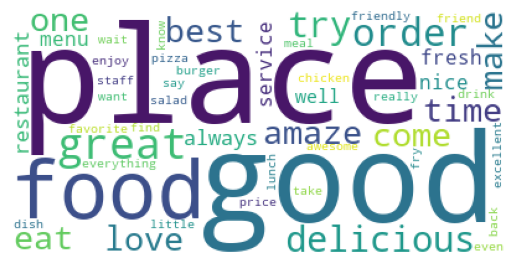


Note = 4


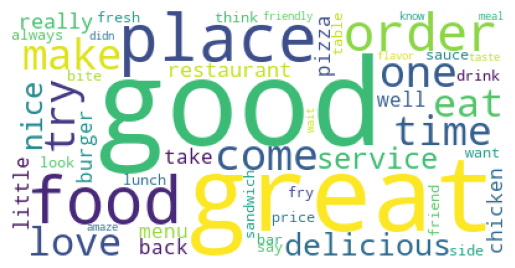


Note = 3


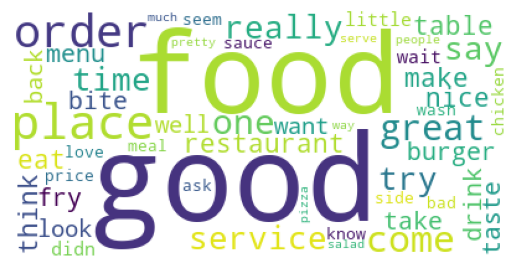


Note = 2


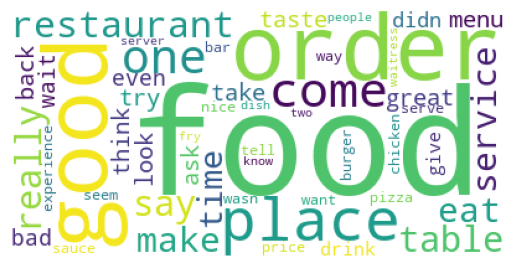


Note = 1


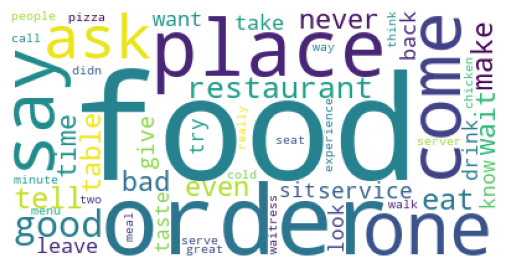

In [19]:
for stars in range(5,0,-1):
    print(f'Note = {stars}')
    display_word_cloud(reviews=get_reviews(stars=stars),
                       no_below=2,
                       no_above= 0.1, 
                       max_words_in_cloud=50)

## Recherche des sujets d'insatisfactions

### Sac de mots (TF-IDF)

In [20]:
def tf_idf(reviews, min_df = 4, max_df = 100, ngram_range=(1,2), verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if verbose > 1: display(reviews.sample(5, random_state=0))


    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words=get_negative_sw(), sublinear_tf=True,ngram_range=ngram_range)
    values = vectorizer.fit_transform(reviews['text'])

    if verbose > 0:
        print('\nVecteurs TF-IDF des reviews:\n====================')
        df = pd.DataFrame(values.toarray(), columns=vectorizer.get_feature_names_out())
        display(df.head())
        
        reviews_vecteurs = []
        reviews.reset_index(inplace=True)
        for index in reviews[reviews['text'].str.len() < 500].sample(5, random_state=0).index:
            review_tfidf = df.iloc[index][df.iloc[index] > 0].to_dict()
            reviews_vecteurs.append([reviews.iloc[index]['text'] , '\n'.join([f'{token}: {tfidf:.4f}' for token, tfidf in review_tfidf.items()])])
        print(tabulate(reviews_vecteurs, headers=['text review', 'vecteur tf-idf'], tablefmt="grid", maxcolwidths=[100, None]))

    return values, vectorizer.get_feature_names_out()

In [21]:
print(f'Vectorisation pour les reviews comportant maximum {bad_stars} étoiles')
reviews = get_reviews(max_stars=bad_stars)
values, features_names = tf_idf(reviews=reviews,
                                min_df=10,
                                max_df=0.1,
                                ngram_range=(1,2),
                                verbose=1)

Vectorisation pour les reviews comportant maximum 2 étoiles
Nombre de textes dupliqués supprimés: 0
Il y a 2000 enregistrements

Vecteurs TF-IDF des reviews:


100  1st  2nd  able  absolute  absolutely  accept  accommodate  \
0  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
1  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
2  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
3  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   
4  0.0  0.0  0.0   0.0       0.0         0.0     0.0          0.0   

   acknowledge  across  ...  yelp       yes  yesterday  yet  york  young  \
0          0.0     0.0  ...   0.0  0.231769        0.0  0.0   0.0    0.0   
1          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
2          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
3          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   
4          0.0     0.0  ...   0.0  0.000000        0.0  0.0   0.0    0.0   

   yuck  yummy      zero  zero star  
0   0.0    0.0  0.000000        0.0  
1   0.0    0.0  0.000000        0.0  
2   0.0    0.0  0.176228        0.0  
3   0.0    0.0  0.000000        0.0  
4   0.0    0.0  0.000000        0.0  

[5 rows x 1901 columns]

+------------------------------------------------------------------------------------------------------+--------------------------+
| text review                                                                                          | vecteur tf-idf           |
+======================================================================================================+==========================+
| You don't accept cash?  I don't think you grasp the ramifications of such a corpo-fascist economic   | accept: 0.2965           |
| principle.  No room for arrogant commies in my diet thank you so very very little.  Can't wait to    | anyone: 0.2395           |
| see this place nosedive  For anyone in the dark about this policy,  watch Mike Judge's film,         | attention: 0.2499        |
| Idiocracy. Pay close attention throughout the hospital scene.   "Unscannable!!!"                     | cash: 0.2758             |
|                                                                           

### LDA Librairie Sklean

In [22]:
def get_topics(reviews: pd.DataFrame, min_df = 4, max_df = 10, n_topics = 10, alpha = 10, n_top_words = 10, ngram_range=(1,1), verbose = 0):

    # pandas width
    pd_width = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 300)
    
    if verbose > 1: print('  - Vectorisation (tf-idf)')
    values, features_names = tf_idf(reviews=reviews, min_df=min_df, max_df=max_df, ngram_range=ngram_range, verbose = 0)

    # Topics from LDA or MDF
    if verbose > 1: print('  - Modélisation LDA')
    model = LatentDirichletAllocation(n_components=n_topics,
                                      max_iter=10,
                                      doc_topic_prior=alpha,
                                      learning_method='online', 
                                      learning_offset=10,
                                      random_state=0,
                                      n_jobs=-1)
    
    model.fit(values)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        features = [features_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    # Restore pandas width
    pd.set_option('display.max_colwidth', pd_width)

    return topics

In [23]:
params = {
    'max_stars': bad_stars,
    'min_df': 2,
    'max_df': 0.1,
    'n_topics': 5,
    'alpha': 0.5,
    'n_top_words': 5,
    'ngram_range': (1,1)
}

print(f'Recherche des sujets avec les paramètres suivants:\n')
print(tabulate([[name, value] for name, value in params.items()], headers=['param', 'valeur']))
print('')
topics = get_topics(reviews=get_reviews(max_stars=bad_stars),
                    min_df=params['min_df'],
                    max_df=params['max_df'],
                    n_topics=params['n_topics'], 
                    alpha=params['alpha'],
                    n_top_words=params['n_top_words'],
                    ngram_range=params['ngram_range'],
                    verbose=3)

Recherche des sujets avec les paramètres suivants:

param        valeur
-----------  --------
max_stars    2
min_df       2
max_df       0.1
n_topics     5
alpha        0.5
n_top_words  5
ngram_range  (1, 1)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  --------------------------------------------
         0  pizza, waitress, burger, sauce, bar
         1  mahi, gun, trio, uncooked, surly
         2  donut, fancy, bueno, wifi, liver
         3  refer, 312, denny, tony, angelo
         4  initially, expense, goopy, preference, legit


In [24]:
params['alpha'] = 0.2
params['max_df'] = 0.2
params['ngram_range'] = (3,3)

print(f'Recherche des sujets avec les paramètres suivants:\n')
print(tabulate([[name, value] for name, value in params.items()], headers=['param', 'valeur']))
print('')
topics = get_topics(reviews=get_reviews(max_stars=bad_stars),
                    min_df=params['min_df'],
                    max_df=params['max_df'],
                    n_topics=params['n_topics'], 
                    alpha=params['alpha'],
                    n_top_words=params['n_top_words'],
                    ngram_range=params['ngram_range'],
                    verbose=3)

Recherche des sujets avec les paramètres suivants:

param        valeur
-----------  --------
max_stars    2
min_df       2
max_df       0.2
n_topics     5
alpha        0.2
n_top_words  5
ngram_range  (3, 3)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  -------------------------------------------------------------------------------------------
         0  would not recommend, waste time money, food good not, not recommend place, not impress food
         1  service very slow, not worth price, make feel like, food not good, food pretty good
         2  food nothing special, get money back, way too much, nothing write home, happy hour menu
         3  take minute get, never come back, would give star, take forever get, give place another
         4  not very good, want like place, not worth wait, really want like, wait another minute


### LDA Librairie Gensim et optimisation du nombre de sujets

In [25]:
def prepare_data(max_stars=2, n_grams=[1,2], no_below=2, no_above=0.1):
    print('  - Préparation des data (preprocess tokenisation...)')

    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=False, verbose=False)
    
    # Preprocess, tokenize and drop stop words
    reviews = get_reviews(max_stars=max_stars)
    texts = reviews['text'].parallel_apply(preprocess_text)
    texts = texts.parallel_apply(tokenize)
    stop_words = get_negative_sw()
    texts = texts.parallel_apply(drop_words, args=(stop_words,))
    
    # Managing n_grams
    texts = texts.parallel_apply(extract_n_grams, args=(n_grams,))

    # list texts
    texts = list(texts)
    
    # create document terms matrix
    dictionary = corpora.Dictionary(texts)
    
    #filter extremes
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    
    corpus = [dictionary.doc2bow(text) for text in texts]

    return texts, dictionary, corpus

def modelize(dictionary, corpus, alpha = 10, num_topics = 10):
    print(f'  - LDA pour {num_topics} topics')
    LDA = gensim.models.ldamodel.LdaModel
    model = LDA(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, random_state=0, chunksize=1000, passes=50,iterations=100)
    return model

def visualize_model(model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis

def print_topics(model):
    topics = []
    for topic in model.show_topics():
        index = topic[0] + 1
        terms = '\n'.join(topic[1].split(' + '))
        topics.append([index, terms])
    
    print(tabulate(topics, headers=['Topic n°', 'mots clés'], tablefmt="grid"))

In [26]:
texts, dictionary, corpus = prepare_data(max_stars=2, n_grams=[2,3], no_below=2, no_above=0.2)
model = modelize(dictionary=dictionary, corpus=corpus, num_topics=5)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 5 topics
+------------+--------------------------+
|   Topic n° | mots clés                |
+============+==========================+
|          1 | 0.005*"come back"        |
|            | 0.004*"taste like"       |
|            | 0.003*"win back"         |
|            | 0.002*"food not"         |
|            | 0.002*"wait staff"       |
|            | 0.002*"felt like"        |
|            | 0.002*"every time"       |
|            | 0.002*"mac cheese"       |
|            | 0.002*"fast food"        |
|            | 0.002*"mexican food"     |
+------------+--------------------------+
|          2 | 0.004*"look like"        |
|            | 0.003*"not return"       |
|            | 0.003*"even though"      |
|            | 0.002*"not sure"         |
|            | 0.002*"good place"       |
|            | 0.002*"good thing"       |
|            | 0.002*"mash potato"      |
|            | 0.002*"like place"       |


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.148311 -0.097005       1        1  20.580602
0     -0.042849  0.052653       2        1  20.199006
4      0.112615  0.179835       3        1  19.898471
1      0.174361 -0.167906       4        1  19.864944
3     -0.095815  0.032423       5        1  19.456976, topic_info=            Term       Freq       Total Category  logprob  loglift
703    last time  36.000000   36.000000  Default  30.0000  30.0000
139   first time  67.000000   67.000000  Default  29.0000  29.0000
2046  last night  36.000000   36.000000  Default  28.0000  28.0000
97    taste like  95.000000   95.000000  Default  27.0000  27.0000
335    look like  56.000000   56.000000  Default  26.0000  26.0000
...          ...        ...         ...      ...      ...      ...
169     food not  17.790611   52.310818   Topic5  -6.3650   0.5584
71      get food  17.468364   61.615343   Topic5  -6.3833   0.3764
112    didn even  16.063440   43.468065   Topic5  -6.4671   0.6415
63     come back  17.554189  121.905557   Topic5  -6.3784  -0.3010
175     not even  14.987818   48.038690   Topic5  -6.5364   0.4722

[328 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1800      5  0.931457    almost hour
1546      1  0.905917  almost minute
4231      2  0.975567    another try
3677      5  0.918649      ask order
2721      1  0.907344     ask waiter
...     ...       ...            ...
1037      2  0.019768      would not
1037      4  0.019768      would not
1037      5  0.652330      would not
3038      3  0.073455    would think
3038      4  0.881458    would think

[536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4])

In [27]:
texts, dictionary, corpus = prepare_data(max_stars=1, n_grams=[3], no_below=2, no_above=0.1)
model = modelize(dictionary=dictionary, corpus=corpus, alpha=20, num_topics=5)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 5 topics
+------------+-----------------------------------+
|   Topic n° | mots clés                         |
+============+===================================+
|          1 | 0.012*"waste time money"          |
|            | 0.011*"never come back"           |
|            | 0.009*"get money back"            |
|            | 0.009*"buy one get"               |
|            | 0.008*"could give zero"           |
|            | 0.008*"would not recommend"       |
|            | 0.008*"take drink order"          |
|            | 0.007*"excite try place"          |
|            | 0.007*"give another chance"       |
|            | 0.007*"come back check"           |
+------------+-----------------------------------+
|          2 | 0.009*"want like place"           |
|            | 0.009*"make eye contact"          |
|            | 0.008*"wish could give"           |
|            | 0.008*"say didn know"             |
|     

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.108142  0.122379       1        1  20.038914
0      0.090220  0.020157       2        1  20.034222
3     -0.078216 -0.038631       3        1  19.990336
4     -0.023514 -0.145471       4        1  19.976336
2      0.119652  0.041566       5        1  19.960192, topic_info=                   Term      Freq      Total Category  logprob  loglift
196      new york pizza  4.000000   4.000000  Default  30.0000  30.0000
385         buy one get  4.000000   4.000000  Default  29.0000  29.0000
570    make eye contact  4.000000   4.000000  Default  28.0000  28.0000
225       take one bite  4.000000   4.000000  Default  27.0000  27.0000
83       get money back  4.000000   4.000000  Default  26.0000  26.0000
..                  ...       ...        ...      ...      ...      ...
214       give one star  1.885276   4.959254   Topic5  -5.3609   0.6442
205      taste like old  1.644789   3.553527   Topic5  -5.4973   0.8411
63      never come back  1.876603  12.071961   Topic5  -5.3655  -0.2500
703  food great service  1.589953   2.839388   Topic5  -5.5313   1.0315
281    call place order  1.572935   2.843788   Topic5  -5.5420   1.0192

[259 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
510       5  0.938971   actually get eat
147       2  0.939828  almost hour drink
71        2  0.939824       ask girl add
182       1  0.176013  ask speak manager
182       3  0.352026  ask speak manager
...     ...       ...                ...
542       3  0.701632   wouldn come back
115       4  0.938682   write bad review
195       2  0.200893    zero star would
195       3  0.200893    zero star would
195       4  0.602678    zero star would

[320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3])

# Classifications des images

## Prévisualisation du dataset

In [28]:
df_photos = pd.read_json('data/original/yelp_photos/photos.json', lines=True)
df_photos.sample(5)

photo_id             business_id  \
134208  i_6XDaeMcutC1gbjqQ9ayQ  fwsPPYt0By1ivuXSXv3wlg   
30826   8xxSSJJI7-FCa5DlKY8ySg  U2hkeMI-q4cS35QolJYN0A   
24400   MXP305EW8NnF-AXdFm-PqA  zobY3ws9R2pgbcP0gOImcg   
85368   MPYc7MXjOSHTnq1w7t-3pw  mu2GzX8oFI78IuhbzkOECQ   
8900    kyLKq70OkBxwiqtNx3X4hw  SxbqEgEwrGmtgvQAgM6kIg   

                          caption   label  
134208                              drink  
30826   Grilled Portabella Nigiri    food  
24400                              inside  
85368               Channa Masala    food  
8900                               inside

In [29]:
df_photos.shape

(200100, 4)

In [30]:
df_photos.label.value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

## Creation dataset echantillons

L'échantillon contient 500 images


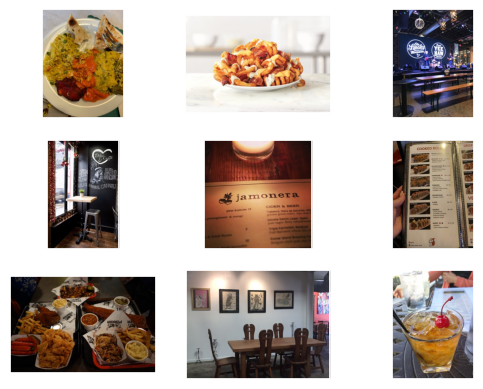

In [31]:
def get_original_photo_path(photo_id):
    return ORIGINAL_PHOTOS_DIR + 'photos/' + photo_id + '.jpg'
    
photo_ids = {}
df_photos_sampling = pd.DataFrame()
for label in df_photos.label.unique():
    photo_ids = list(df_photos[df_photos.label == label].sample(SAMPLING_PHOTOS_SIZE, random_state=0)['photo_id'])
    df_label = pd.DataFrame({
        'photo_id': photo_ids,
        'label': np.full(len(photo_ids), label),
        'width': np.zeros(len(photo_ids)), 
        'height': np.zeros(len(photo_ids)), 
        'mode': np.full(len(photo_ids), '')
    })
    df_photos_sampling = pd.concat([df_photos_sampling, df_label], ignore_index=True)

label_encoder = LabelEncoder()
df_photos_sampling['label_num'] = label_encoder.fit_transform(df_photos_sampling['label'])

print(f'L\'échantillon contient {df_photos_sampling.shape[0]} images')

sample_ids = list(df_photos_sampling.sample(9, random_state=1)['photo_id'])
for i in range(9):
    plt.subplot(330 + 1 + i)
    image = matplotlib.image.imread(get_original_photo_path(sample_ids[i]))
    plt.imshow(image)
    plt.grid(linewidth=0)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.show()

In [32]:
def fill_infos(df):
    for index in df.index:
        print(f'Lecture infos image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        img = Image.open(get_original_photo_path(photo_id))
        
        w, h = img.size
        df.loc[df['photo_id']==photo_id, 'height'] = h   
        df.loc[df['photo_id']==photo_id, 'width'] = w
        df.loc[df['photo_id']==photo_id, 'mode'] = img.mode

fill_infos(df_photos_sampling)
df_photos_sampling.sample(5)

photo_id    label  width  height mode  label_num
116  CYZlkikj8YSiiPgovWzLkg  outside  300.0   400.0  RGB          4
133  L1DJ9cPIpuX0g0oISQkAKA  outside  300.0   400.0  RGB          4
234  6uvA7j38q5oPcPBVcZ0w5w    drink  533.0   400.0  RGB          0
136  eSYgcw55spHQMNuQw4Jv_Q  outside  533.0   400.0  RGB          4
106  xERa4A4XR5LURhORPmXogg  outside  320.0   270.0  RGB          4

In [33]:
df_photos_sampling.describe()

width      height  label_num
count  500.000000  500.000000  500.00000
mean   438.882000  389.688000    2.00000
std    131.985303   32.814085    1.41563
min    131.000000   69.000000    0.00000
25%    300.000000  400.000000    1.00000
50%    408.000000  400.000000    2.00000
75%    543.750000  400.000000    3.00000
max    600.000000  400.000000    4.00000

In [34]:
df_photos_sampling['mode'].value_counts()

mode
RGB    500
Name: count, dtype: int64

## Clustering par descripteurs SIFT

In [35]:
df_sift = df_photos_sampling.copy()

### Pretraitement des images

In [36]:
def preprocess_images_sift(df):
    for index in df.index:
        print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image_sift(photo_id)

def preprocess_image_sift(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        img = display_img(original_path)
        img = histo_rgb(img)
    else:
        img = Image.open(original_path)
    
    img = treat_histogram(img)
    img = filter_img(img)
    new_path = save_img(current_path=original_path, img=img, work_part='sift')

    if display_evo:
        img = display_img(new_path)
        img = histo_rgb(img)
    
    return new_path
    
def display_img(path):
    img = Image.open(path)
    display(img)
    return img

def histo_rgb(img):
    r, g, b = img.split()
    fig, axs = plt.subplots(1,3, figsize=(10,5), sharey=True)
    chans = {'rouge': r, 'vert': g, 'bleu':b}
    for index, name in enumerate(chans):
        chan_flat = np.array(chans[name]).flatten()
        ax = sns.histplot(chan_flat, bins=range(256), ax=axs[index])
        ax.set(ylabel=None,
               title=f'Channel: {name}')
    fig.supxlabel('Intensité')
    fig.supylabel('Nombre de pixels')
    plt.show()

    return img

def treat_histogram(img):
    # Equalize and autocontrast
    img = ImageOps.equalize(img)
    img = ImageOps.autocontrast(img)
    return img
    

def filter_img(img):
    # Apply gaussian blur
    img = img.filter(ImageFilter.MedianFilter(size=3))
    return img

def save_img(current_path, img, work_part):
    filename = os.path.basename(current_path)
    new_path = WORK_PHOTOS_DIR + work_part + '/' + filename
    img.save(new_path)

    return new_path

#### Exemple de pre-traitement

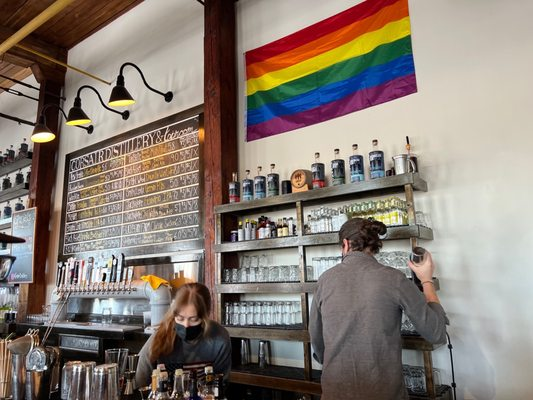

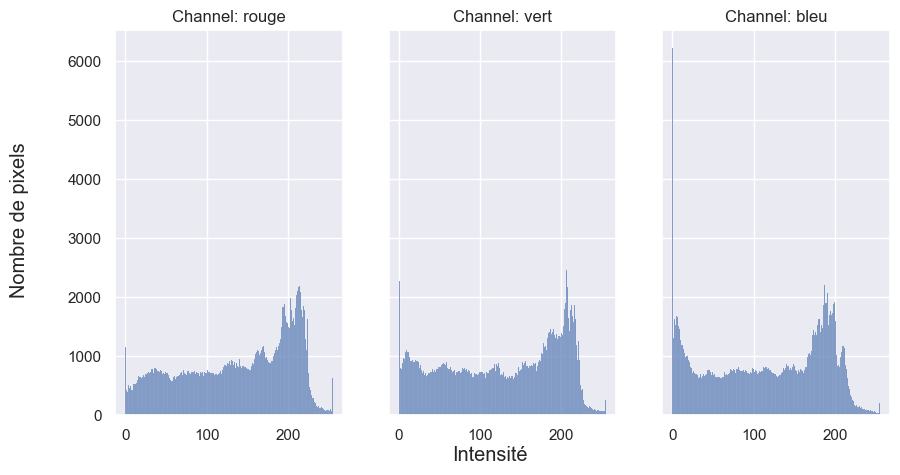

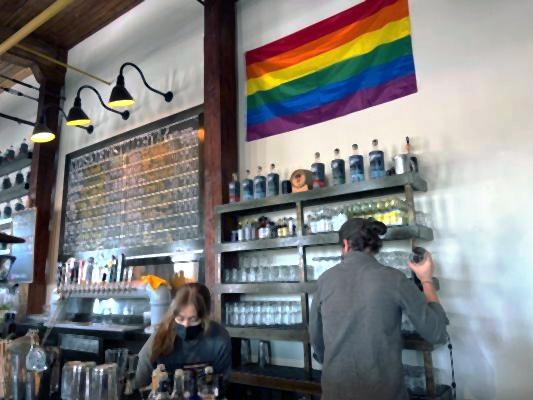

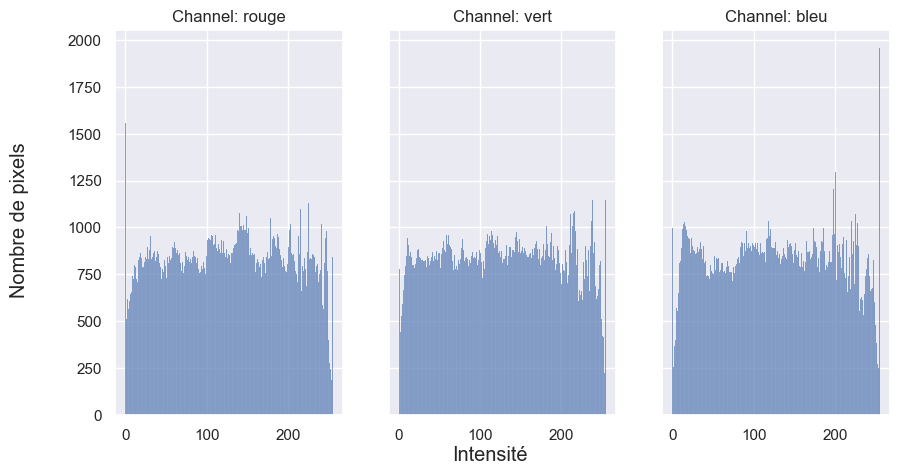

'data/work/yelp_photos/sift/1KfbK9IcrbxY1lUkvN1aUA.jpg'

In [37]:
photo_id_sample = df_sift.sample(1, random_state=0)['photo_id'].iloc[0]
preprocess_image_sift(photo_id_sample,display_evo=True)

#### Pretaitement de l'ensemble de l'échantillon

In [38]:
if PREPROCESS_IMAGES:
    preprocess_images_sift(df=df_sift)

### Creation des descripteurs

In [39]:
def get_descripteurs(photo_id, max_desc=500, work_dir = WORK_PHOTOS_DIR, plot = False, print_desc = False):
    import cv2
    sift = cv2.xfeatures2d.SIFT_create(max_desc)
    image = cv2.imread(work_dir + 'sift/' + photo_id + '.jpg')
    kp, desc = sift.detectAndCompute(image, None)

    if plot:
        img=cv2.drawKeypoints(image,kp,image)
        plt.imshow(img)
        plt.grid(linewidth=0)
        plt.show()

    if print_desc:
        print("Descripteurs : ", desc.shape)
        print()
        print(desc)
    
    return desc    

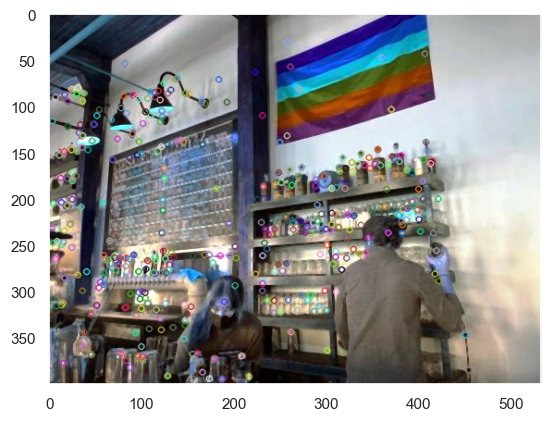

Descripteurs :  (501, 128)

[[ 0.  0.  0. ...  1. 18. 18.]
 [13. 14.  8. ... 24.  0.  1.]
 [24.  0.  0. ...  2.  5. 25.]
 ...
 [ 0.  0.  0. ...  0.  2.  8.]
 [ 0.  0.  0. ...  0.  2. 13.]
 [ 0.  0. 10. ...  0.  0. 12.]]


In [40]:
desc = get_descripteurs(photo_id=photo_id_sample, plot=True, print_desc=True)

In [41]:
pandarallel.initialize(progress_bar=True, verbose=False)
descripteurs = df_sift['photo_id'].parallel_apply(get_descripteurs, args=(500,))
df_sift['desc'] = descripteurs
display(df_sift.sample(3))
num_img_desc = df_sift['desc'][0].shape[0]

photo_id   label  width  height mode  label_num  \
355  99qtcovdFqthYUJqv4rqEw    food  400.0   400.0  RGB          1   
262  i7YlhkiBpJrM2sCpECbLjA   drink  400.0   400.0  RGB          0   
36   q309S38cq36epyojc-ptTA  inside  533.0   400.0  RGB          2   

                                                  desc  
355  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0...  
262  [[10.0, 14.0, 15.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1...  
36   [[0.0, 0.0, 0.0, 2.0, 25.0, 6.0, 1.0, 1.0, 87....

### Clustering des descripteurs

In [42]:
all_descripteurs = np.concatenate(df_sift['desc'].values, axis=0)
n_clusters = math.floor(math.sqrt(len(all_descripteurs)))
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=512, random_state=0, n_init="auto").fit(all_descripteurs)
print(f'Il y a {n_clusters} clusteurs pour un total de {len(all_descripteurs)} descripteurs')

Il y a 494 clusteurs pour un total de 244744 descripteurs


### Creations des features des images

In [43]:
def features_sift(descripteurs, kmeans: MiniBatchKMeans):
    import numpy as np
    desc_clusters = kmeans.predict(descripteurs)
    return np.histogram(desc_clusters, bins=kmeans.n_clusters, range=(0, kmeans.n_clusters))[0]

features = df_sift['desc'].parallel_apply(features_sift, args=(kmeans,))
df_sift['features'] = features
df_sift.sample(3)

photo_id    label  width  height mode  label_num  \
156  Y9bJTSOMcpOmfY8ml8DzRg  outside  300.0   400.0  RGB          4   
84   ZhPb-006uRxv6D2iuGsLNg   inside  533.0   400.0  RGB          2   
426  jEa3Y6D_YHrXu8ZDzHFOVw     menu  300.0   400.0  RGB          3   

                                                  desc  \
156  [[116.0, 6.0, 0.0, 0.0, 2.0, 1.0, 0.0, 10.0, 1...   
84   [[2.0, 5.0, 37.0, 8.0, 0.0, 1.0, 3.0, 3.0, 51....   
426  [[0.0, 1.0, 97.0, 56.0, 0.0, 0.0, 0.0, 0.0, 0....   

                                              features  
156  [0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 0, 1, 1, ...  
84   [1, 0, 3, 2, 1, 1, 1, 0, 1, 1, 0, 7, 0, 0, 0, ...  
426  [0, 4, 0, 0, 0, 5, 0, 3, 0, 0, 0, 2, 0, 1, 2, ...

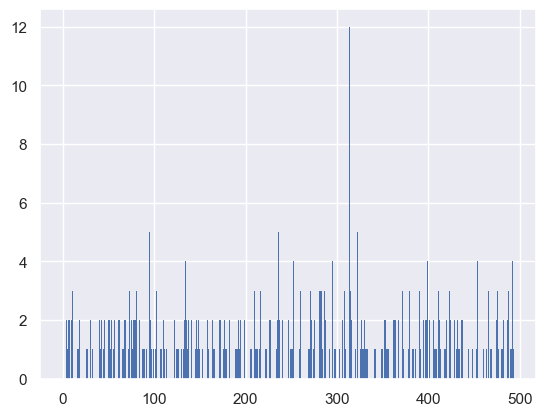

In [44]:
features_sample = df_sift['features'][0]
plt.bar(range(len(features_sample)), features_sample, linewidth=0)
plt.show()

### Reduction de dimension puis clustering

In [64]:
def acp(X, keep_variance = 0.99):
    print('Reduction PCA')
    pca = PCA(n_components=keep_variance, svd_solver='full')
    features_pca = pca.fit_transform(X)
    old_shape = np.array(X)[0].shape[0]
    new_shape = features_pca.shape[1]
    print(f'En concervant {keep_variance*100}% de la variance, la PCA réduit les features de {old_shape} composantes à {new_shape} composantes') 

    return features_pca

def tsne_df(df, label, features, x_tsne, y_tsne):
    print('Reduction TSNE en 2 dimensions')
    tsne = TSNE(n_components=2, perplexity=20, n_iter=15000, init='random', random_state=0)
    X_tsne = tsne.fit_transform(features)
    
    df[x_tsne] = X_tsne[:,0:1]
    df[y_tsne] = X_tsne[:,1:2]
    
    sns.scatterplot(df, x=x_tsne, y=y_tsne, hue=label)
    plt.show()

def clustering(df, X, label, predict):
    print('Clustering')
    n_clusters = df[label].nunique()
    kmean_final = MiniBatchKMeans(n_clusters=5, batch_size=512, random_state=0, n_init="auto").fit(X)
    df[predict] = kmean_final.predict(X)

def graph_predict(df, x, y, label, predict, label_classes):
    print('Affichage des clusters')
    sns.scatterplot(df, x=x, y=y, hue=predict)

    labels_true = list(df[label])
    labels_pred = list(df[predict])
    
    conf_mat = confusion_matrix(labels_true, labels_pred)
    plt.figure(figsize = (6,4))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", yticklabels=label_classes)
    plt.show()

    ars = adjusted_rand_score(labels_pred=labels_pred, labels_true=labels_true)
    print(f'Adjusted rand score = {ars:.3f}')

def pca_tsne_clustering(df, x_tsne, y_tsne, predict, pca_keep_variance=0.99):
    # Step 1: PCA
    X_pca = list(df['features'])
    features_pca = acp(X_pca, keep_variance=pca_keep_variance)

    # Step 2 : Tsne
    tsne_df(df=df, label='label', features=features_pca, x_tsne=x_tsne, y_tsne=y_tsne)

    # Step 3: Clustering
    X_clustering = np.array([df[x_tsne], df[y_tsne]]).T
    clustering(df=df, X=X_clustering, label='label', predict=predict)

    # Step 4: Graph clustering
    graph_predict(df=df, x=x_tsne, y=y_tsne, label='label_num', predict=predict, label_classes=label_encoder.classes_)

def clustering_pca_tsne(df, x_tsne, y_tsne, predict, pca_keep_variance=0.99):
    # Step 1: Clustering
    X_clustering = list(df['features'])
    clustering(df=df, X=X_clustering, label='label', predict=predict)

    # Step 2: PCA
    X_pca = list(df['features'])
    features_pca = acp(X_pca, keep_variance=pca_keep_variance)

    # Step 3 : Tsne
    tsne_df(df=df, label='label', features=features_pca, x_tsne=x_tsne, y_tsne=y_tsne)

    # Step 4: Graph clustering
    graph_predict(df=df, x=x_tsne, y=y_tsne, label='label_num', predict=predict, label_classes=label_encoder.classes_)

def pca_clustering_tsne(df, x_tsne, y_tsne, predict, pca_keep_variance=0.99):
    # Step 1: PCA
    X_pca = list(df['features'])
    features_pca = acp(X_pca, keep_variance=pca_keep_variance)
    
    # Step 2: Clustering
    X_clustering = features_pca
    clustering(df=df, X=X_clustering, label='label', predict=predict)

    # Step 3 : Tsne
    tsne_df(df=df, label='label', features=features_pca, x_tsne=x_tsne, y_tsne=y_tsne)

    # Step 4: Graph clustering
    graph_predict(df=df, x=x_tsne, y=y_tsne, label='label_num', predict=predict, label_classes=label_encoder.classes_)

Reduction PCA
En concervant 99.0% de la variance, la PCA réduit les features de 494 composantes à 343 composantes
Reduction TSNE en 2 dimensions


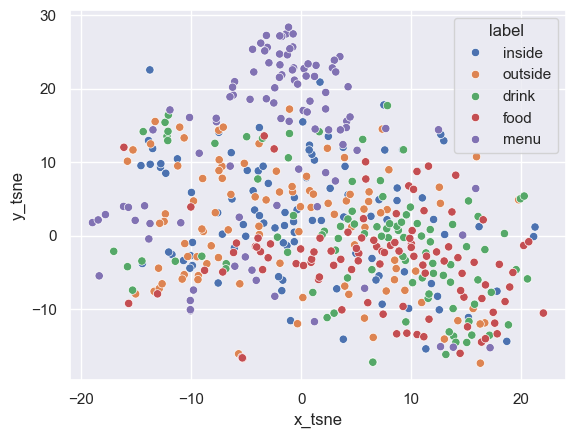

Clustering
Affichage des clusters


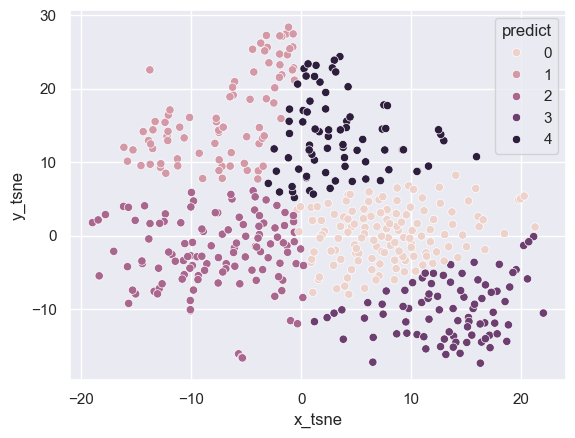

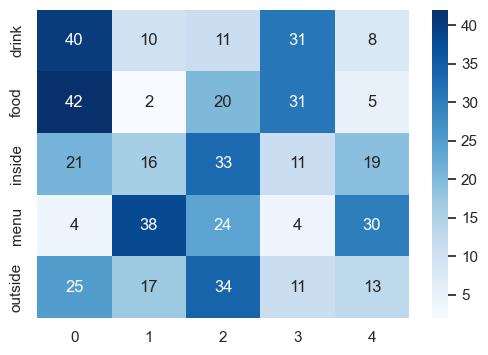

Adjusted rand score = 0.068


In [60]:
pca_tsne_clustering(df=df_sift, x_tsne='x_tsne', y_tsne='y_tsne', predict = 'predict')

## Clustering par CNN

In [49]:
df_cnn = df_photos_sampling.copy()

### Pretraitement des images

In [50]:
(width_max, height_max) = (int(df_cnn['width'].max()), int(df_cnn['height'].max()))

In [51]:
from PIL import Image, ImageOps

def preprocess_images_cnn(df):
    for index in df.index:
        print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image_cnn(photo_id)

def preprocess_image_cnn(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        img = display_img(original_path)
        print(f'Taille originale => Hauteur: {img.height}, Largeur: {img.width}')
    else:
        img = Image.open(original_path)

    border_width_1 = (width_max - img.width) // 2
    border_width_2 = width_max - img.width - border_width_1
    
    border_height_1 = (height_max - img.height) // 2
    border_height_2 = height_max - img.height - border_height_1
    
    img = ImageOps.expand(img,border=(border_width_1, border_height_1, border_width_2, border_height_2),fill='black')
    
    new_path = save_img(current_path=original_path, img=img, work_part='cnn')

    if display_evo:
        img = display_img(new_path)
        print(f'Taille ajustée => Hauteur: {img.height}, Largeur: {img.width}')
    
    return new_path

### Exemple de pré-traitement

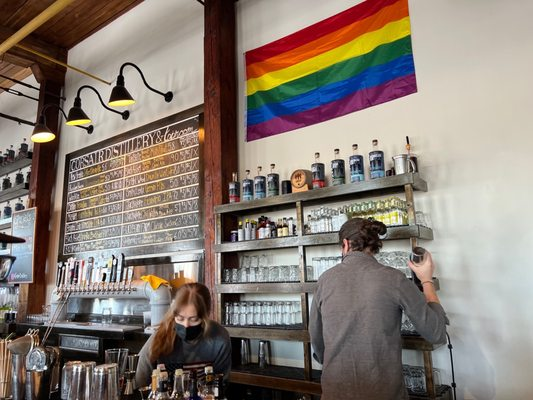

Taille originale => Hauteur: 400, Largeur: 533


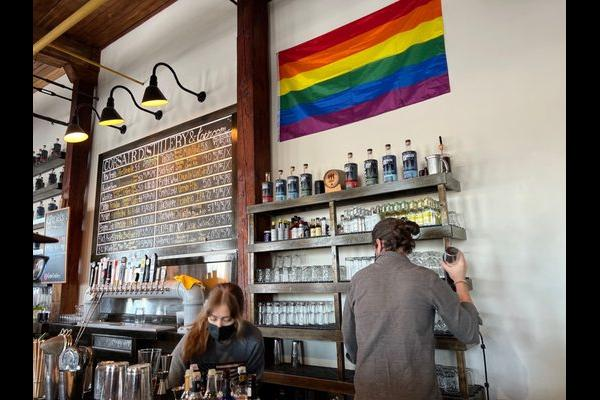

Taille ajustée => Hauteur: 400, Largeur: 600


'data/work/yelp_photos/cnn/1KfbK9IcrbxY1lUkvN1aUA.jpg'

In [52]:
preprocess_image_cnn(photo_id=photo_id_sample, display_evo=True)

### Pré-traitement de l'ensemble de l'échantillon

In [53]:
if PREPROCESS_IMAGES:
    preprocess_images_cnn(df=df_cnn)

### Creation des features depuis cnn VGG16

In [54]:
from keras.applications.vgg16 import VGG16
from keras import Input
input = Input(shape=(height_max, width_max, 3))
model = VGG16(include_top=False,input_tensor=input, weights='imagenet', pooling='max')
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 600, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 600, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 600, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 300, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 300, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 300, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 150, 128)     0     

In [55]:
import keras
def features_cnn(photo_id, model, work_dir = WORK_PHOTOS_DIR):
    img_path = work_dir + 'cnn/' + photo_id + '.jpg'
    img = keras.utils.load_img(img_path)
    x = keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = keras.applications.vgg16.preprocess_input(x)
    features = model.predict(x)
    
    return features[0, :]

In [56]:
if EXTRACT_CNN_FEATURES:
    features = df_cnn['photo_id'].apply(features_cnn, args=(model,))
    df_cnn['features'] = features
    df_cnn.to_parquet('df_cnn')
    df_cnn.sample(3)
else:
    df_cnn = pd.read_parquet('df_cnn')

In [57]:
df_cnn

photo_id   label  width  height mode  label_num  \
0    4bCgKE0Itp0T8wQXpYsypg  inside  458.0   400.0  RGB          2   
1    RN1AVvw1HXLceaNJkI0GdQ  inside  300.0   400.0  RGB          2   
2    XDVvq4N-wZV5jKVSUYXI2Q  inside  300.0   400.0  RGB          2   
3    IBCtJNh1XJApQSCSzLznlw  inside  533.0   400.0  RGB          2   
4    XIiiz9u9TY5CWjWlUW4pOg  inside  533.0   400.0  RGB          2   
..                      ...     ...    ...     ...  ...        ...   
495  jxxdyVxLYxoAZx_u0Nk15Q    menu  508.0   400.0  RGB          3   
496  gOZd2DVI9UJ7H2P3tl3L0w    menu  259.0   400.0  RGB          3   
497  CmXqOedu60VEv5DNP-uOUQ    menu  266.0   400.0  RGB          3   
498  yS8ClmejCknInl9qOCtyVQ    menu  300.0   400.0  RGB          3   
499  x4acVHke3X7o6hrVaulmQA    menu  533.0   400.0  RGB          3   

                                              features  
0    [35.223938, 33.700726, 25.60686, 12.462739, 3....  
1    [70.471504, 36.02751, 12.21764, 0.0, 39.121506...  
2    [3.3377254, 3.9449198, 0.0, 28.995647, 50.5171...  
3    [47.970963, 31.787832, 21.953196, 19.160604, 3...  
4    [0.0, 62.49378, 28.536165, 76.32434, 79.88776,...  
..                                                 ...  
495  [107.8648, 62.93106, 60.27255, 18.555782, 36.3...  
496  [0.0, 23.820013, 0.0, 0.0, 0.82622284, 0.0, 0....  
497  [3.0549815, 67.442375, 6.7906957, 0.0, 4.54891...  
498  [0.0, 0.0, 60.30077, 0.0, 11.849307, 3.311071,...  
499  [12.708604, 0.0, 0.0, 7.721679, 76.81374, 29.1...  

[500 rows x 7 columns]

### Test 1: PCA -> TSNE -> KMEAN

Reduction PCA
En concervant 99.0% de la variance, la PCA réduit les features de 512 composantes à 339 composantes
Reduction TSNE en 2 dimensions


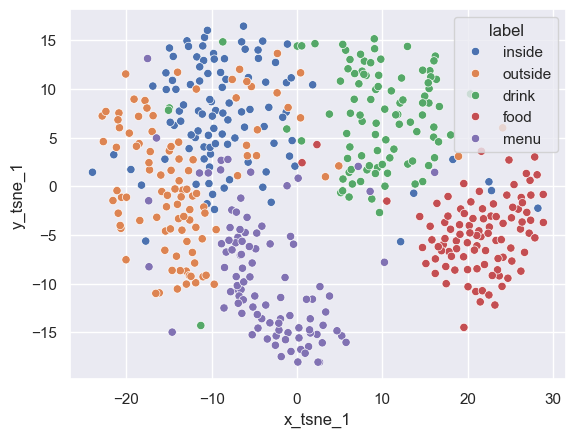

Clustering
Affichage des clusters


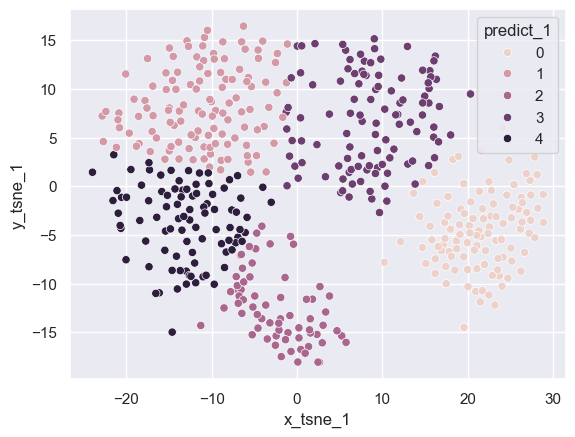

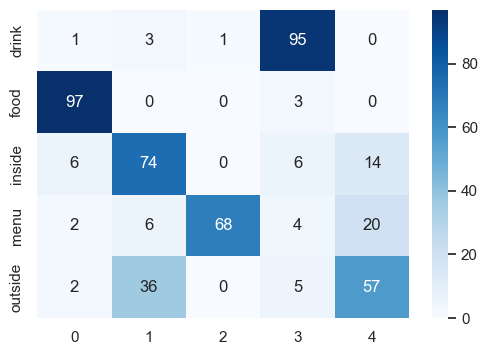

Adjusted rand score = 0.578


In [61]:
pca_tsne_clustering(df=df_cnn, x_tsne='x_tsne_1', y_tsne='y_tsne_1', predict='predict_1')

### Test 2: KMEAN -> PCA -> TSNE

Clustering
Reduction PCA
En concervant 99.0% de la variance, la PCA réduit les features de 512 composantes à 339 composantes
Reduction TSNE en 2 dimensions


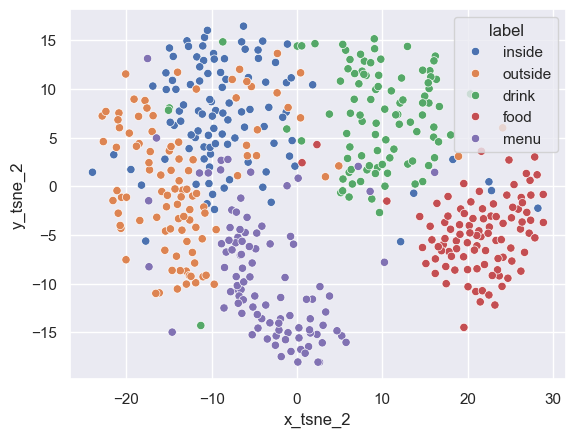

Affichage des clusters


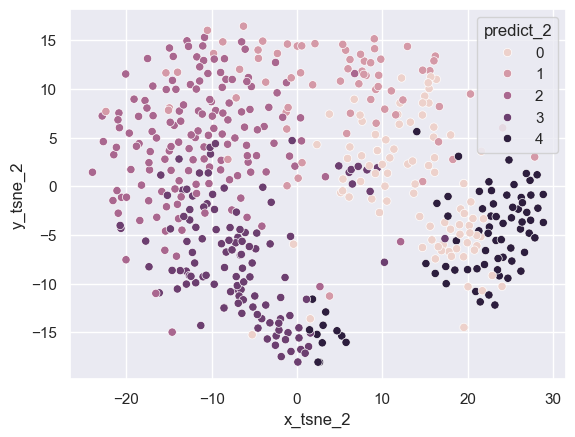

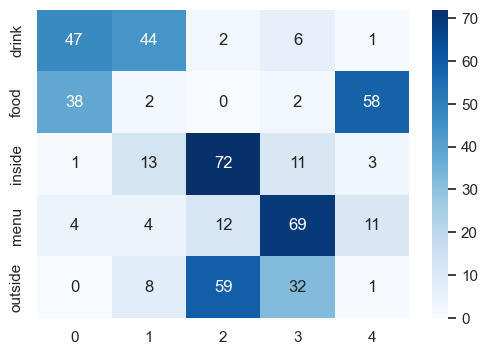

Adjusted rand score = 0.318


In [62]:
clustering_pca_tsne(df=df_cnn, x_tsne='x_tsne_2', y_tsne='y_tsne_2', predict='predict_2')

### Test 3: PCA (50% variance) -> KMEAN -> TSNE

Reduction PCA
En concervant 50.0% de la variance, la PCA réduit les features de 512 composantes à 21 composantes
Clustering
Reduction TSNE en 2 dimensions


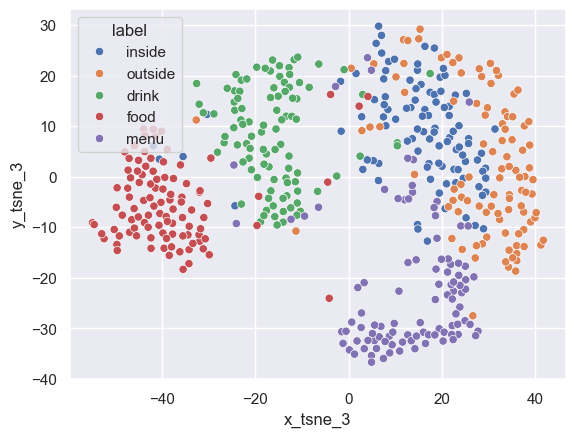

Affichage des clusters


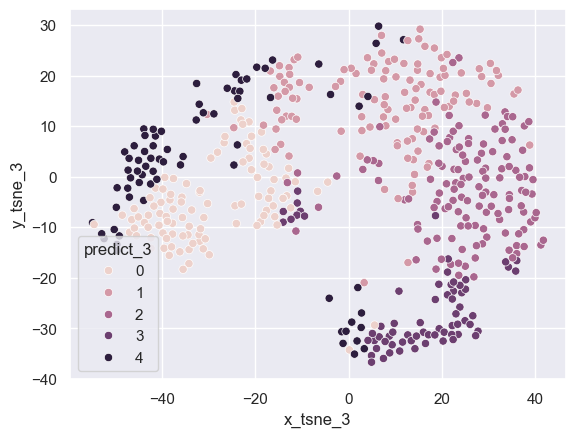

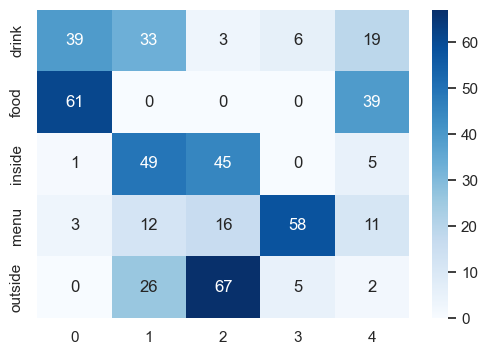

Adjusted rand score = 0.269


In [65]:
pca_clustering_tsne(df=df_cnn, x_tsne='x_tsne_3', y_tsne='y_tsne_3', predict='predict_3', pca_keep_variance=0.5)